In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
car_df = pd.read_csv('clean_signals.csv')

car_df['timestamp'] = pd.to_datetime(car_df['timestamp'])

car_df.shape

(1953951, 20)

In [87]:
signal_cols = ['speed', 'acc_x', 'acc_y', 'acc_z']
target_cols = ['device_id', 'trip_id', 'timestamp'] + signal_cols

In [4]:
complete_driving_df = car_df[car_df['is_complete'] == True][target_cols]
    
complete_driving_df.head()

,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z
183104,1,1,2018-01-24 19:48:01,3,-0.023588,-0.061869,-0.044745
183105,1,1,2018-01-24 19:48:02,2,-0.261130,-0.781108,-0.566984
183106,1,1,2018-01-24 19:48:03,0,-0.252172,-0.782251,-0.586721
183107,1,1,2018-01-24 19:48:04,0,-0.251845,-0.809530,-0.538245
183108,1,1,2018-01-24 19:48:05,0,-0.229758,-0.806974,-0.552653


In [5]:
def device_driving_history(df):

    df['day_of_the_month'] = df['timestamp'].dt.day.astype(str)

    return df[['device_id', 'day_of_the_month']]\
        .drop_duplicates()\
        .groupby(['device_id'])\
        .agg({'day_of_the_month': lambda x: ', '.join(x.values)})

device_driving_history(complete_driving_df.copy())

,day_of_the_month
device_id,
1,"24, 25"
2,"16, 19, 20, 21"
3,"11, 12, 21, 28, 31"
5,"10, 12, 13, 15, 16, 17, 19, 20, 22"
6,"29, 31"
7,"12, 16, 18, 21, 30"
8,29
10,"1, 3, 9, 13, 19, 20, 28, 29, 30"
11,31


In [6]:
def extract_driving_period(df):
    
    driving_period_list = list()
    
    for i, ((device_id, trip_id), group_df) in enumerate(df.groupby(['device_id', 'trip_id'])):
        group_df = group_df.reset_index(drop=True)\
            .reset_index()\
            .rename(columns={'index': 'time_step'})

        # Drop the first record to smooth the signals
        group_df = group_df.loc[1:]

        # Fine the time before stopping the card. 
        driving_time_index = group_df[group_df['speed'] > 0]
        time_before_driving = driving_time_index.index.min()
        time_before_stop = driving_time_index.index.max()
        
        # Remove the records of stopping.
        group_df = group_df.loc[np.maximum(0, time_before_driving-5): time_before_stop+5]
        
        if ~np.isnan(time_before_stop) and group_df.shape[0] > 50:
            driving_period_list.append(group_df)
            
    return pd.concat(driving_period_list, ignore_index=True)

In [10]:
driving_df = extract_driving_period(complete_driving_df)

In [48]:
def plot_driving_period(df):
    for i, ((device_id, trip_id), group_df) in enumerate(df.groupby(['device_id', 'trip_id'])):
        group_df = group_df.reset_index(drop=True).reset_index()

        plt.figure()
        _, axes = plt.subplots(2, 1, figsize=(12, 4))
        sns.lineplot(x=group_df['index'], y=group_df['acc_x'], ax=axes[0], color='blue')
        sns.lineplot(x=group_df['index'], y=group_df['acc_y'], ax=axes[0], color='green')
        sns.lineplot(x=group_df['index'], y=group_df['acc_z'], ax=axes[0], color='red')
        axes[0].set_title('Accelerometer signals for device id: {} | trip id: {}'.format(device_id, trip_id))
        axes[0].set_ylabel('Amplitude')
        axes[0].legend(labels=['x', 'y', 'z'], loc='upper right')
        sns.lineplot(x=group_df['index'], y=group_df['speed'], ax=axes[1], color='grey')\
            .set_xlabel('Time step (sec)')
    
        if i == 1: break

<Figure size 432x288 with 0 Axes>

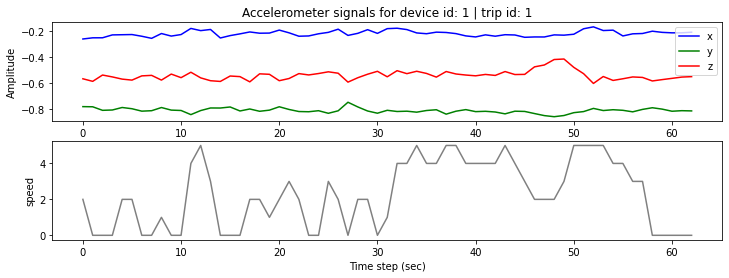

<Figure size 432x288 with 0 Axes>

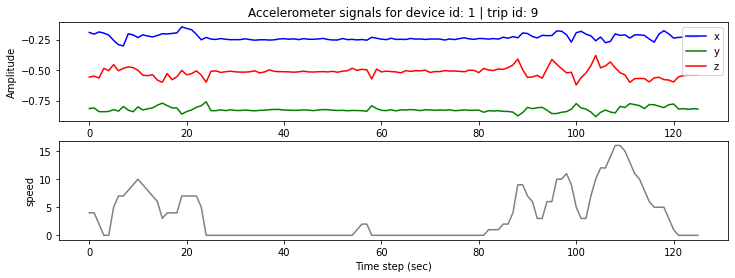

In [49]:
plot_driving_period(driving_df)

### Driving length distribution
All the driving lengths are longer than 50 seconds. **We can use 50 time steps as a window to build features**.

In [23]:
driving_length = driving_df[['device_id', 'trip_id', 'time_step']]\
    .groupby(['device_id', 'trip_id'])\
    .count()\
    .rename(columns={'time_step': 'driving length (sec)'})['driving length (sec)']

Text(0.5, 1.0, 'Driving length distribution')

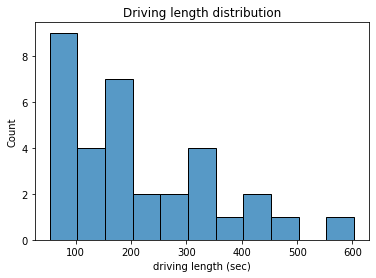

In [29]:
sns.histplot(driving_length, binwidth=50).set_title("Driving length distribution")

### Transform signals into window samples

In [51]:
driving_df.head()

,time_step,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z
0,1,1,1,2018-01-24 19:48:02,2,-0.261130,-0.781108,-0.566984
1,2,1,1,2018-01-24 19:48:03,0,-0.252172,-0.782251,-0.586721
2,3,1,1,2018-01-24 19:48:04,0,-0.251845,-0.809530,-0.538245
3,4,1,1,2018-01-24 19:48:05,0,-0.229758,-0.806974,-0.552653
4,5,1,1,2018-01-24 19:48:06,2,-0.228376,-0.787745,-0.569626


In [53]:
driving_df[['device_id', 'trip_id', 'time_step']]

,device_id,trip_id,time_step
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5
...,...,...,...
6936,11,9,568
6937,11,9,569
6938,11,9,570
6939,11,9,571


In [54]:
import numpy as np
from numpy.lib.stride_tricks import as_strided


def windowed_view(arr, window, overlap):
    """ Apply rolling windows into the array with an overlap
    """
    
    arr = np.asarray(arr)
    window_step = window - overlap
    new_shape = arr.shape[:-1] + ((arr.shape[-1] - overlap) // window_step, window)
    new_strides = (arr.strides[:-1] + (window_step * arr.strides[-1],) + arr.strides[-1:])
    
    return as_strided(arr, shape=new_shape, strides=new_strides)

In [84]:
def create_window_samples(df, window, overlap):
    
    window_samples_list = list()
    labels_list = list()
    
    for (device_id, trip_id), trip_df in df.groupby(['device_id', 'trip_id']):
        trip_length = trip_df.shape[0]
        window_samples = windowed_view(trip_df['time_step'], window, overlap)
        labels = np.full((window_samples.shape[0],), device_id)
        window_samples_list.append(window_samples)
        labels_list.append(labels)

    return np.concatenate(window_samples_list), np.concatenate(labels_list)

In [85]:
window_samples, labels = create_window_samples(driving_df, window=50, overlap=25)

In [93]:
def extract_signals_per_window(df, window_samples, target_cols):
    
    signal_window_samples_list = list()
    
    for window in window_samples:
        signal_window_samples_list.append(df.loc[window][target_cols].values)
    
    return np.asarray(signal_window_samples_list)

In [94]:
signal_window_samples = extract_signals_per_window(driving_df, window_samples, signal_cols)

In [95]:
signal_window_samples.shape

(228, 50, 4)

### Trip analysis
- number of unique trips
- trip duration distribution
- trips per car
- drive speed analysis (overspeeding) time spent on each speed bucket
- time of idling with engine on per trip

#### Behavior Analysis
- trips completed per user
- total drive time per user
- drive time per trip
- trip distance
- trip history?


- day driving time vs. night driving time (night time can be 11pm to 4am)
- day driving is safter than night driving


- hardbrakes
- rash acceleration (hard accelerate)
- drive speed (km/hr), overspeeding
- idling with engine on (idling on a public road is dangerous. idling is not environmental friendly and burns the same amount of oil as driving.)

#### Customer Segmentation
Build driving behavior features for clustering, and analyse the commonality in each group. But customer profiling with more meaningful background information can make features more representative.

Beside, we don't have any customer information in the data.

#### Customer Safety Analysis
Some customers are more risky while driving. It causes a high chance to car accidents. It impacts car availability.